# GNN for Link + Vote Prediction

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Link existence**: will *u* vote on *t*? (`NoVote` vs `Voted`)
- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

We output a 4-class prediction, but train hierarchically with two heads: link existence and vote polarity.

Key implementation choices:
- **No leakage**: message passing uses only **training positive edges**.
- **Mini-batch training** with **LinkNeighborLoader**: each batch samples a subgraph around the queried links.
- **Negative sampling**: we create `NoVote` examples by sampling users who did **not** vote for the same candidate.

## Setup

In [1]:
# Import standard libraries
import sys, random
from pathlib import Path
from collections import defaultdict
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [2]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('Tarc', np.int64(9343)), ('Gen. von Klinkerhoffen', np.int64(3719)), ('Lobojo', np.int64(5720)), ('King Dracula', np.int64(5348)), ('Islanders27', np.int64(4553)), ('Neckername', np.int64(6773)), ('Isaiahcambron', np.int64(4540)), ('Dayewalker', np.int64(2478)), ('SkArcher', np.int64(8754)), ('P4k', np.int64(7213))]


In [4]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Train - Validation - Test split

This function divide the whole dataset in three parts based on the date. The outputs are ordered by date.

**idea:** maby we should quantize about the month not about the day

In [5]:
def train_val_test_split_by_date(X, y, dates, val_ratio=0.1, test_ratio=0.05):
    """
    Splits edges into train, validation, and test sets based on date.
    Edges with the earliest dates go to training, then validation, then test.
    """
    # Convert to numpy for easier sorting
    X_np = X.numpy()
    y_np = y.numpy()
    dates_np = np.array(dates)

    # Get sorted indices based on dates
    sorted_indices = np.argsort(dates_np)

    num_edges = len(dates_np)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    num_train = num_edges - num_val - num_test

    train_indices = sorted_indices[:num_train]
    val_indices = sorted_indices[num_train:num_train + num_val]
    test_indices = sorted_indices[num_train + num_val:]

    X_train = torch.tensor(X_np[train_indices], dtype=torch.long)
    y_train = torch.tensor(y_np[train_indices], dtype=torch.long)

    X_val = torch.tensor(X_np[val_indices], dtype=torch.long)
    y_val = torch.tensor(y_np[val_indices], dtype=torch.long)

    X_test = torch.tensor(X_np[test_indices], dtype=torch.long)
    y_test = torch.tensor(y_np[test_indices], dtype=torch.long)

    return (X_train, y_train, dates_np[train_indices]), (X_val, y_val, dates_np[val_indices]), (X_test, y_test, dates_np[test_indices])

(X_tr_pos, y_tr_pos, dates_tr), (X_val_pos, y_val_pos, dates_val), (X_test_pos, y_test_pos, dates_test) = train_val_test_split_by_date(X, y_pos, dates)

# Splits summary
print(f"Training set shape: {X_tr_pos.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val_pos.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test_pos.shape} between dates {dates_test.min()} and {dates_test.max()}")

Training set shape: torch.Size([160495, 2]) between dates 20030816 and 20100413
Validation set shape: torch.Size([18881, 2]) between dates 20100413 and 20120305
Test set shape: torch.Size([9440, 2]) between dates 20120305 and 20130605


## Data structure creation

The structure will contain only edges in the training set to avoid data leakage.

Features are initialized using knowledge gained from the training set containing 

- in degree (votes received)
- out degree (votes given)
- Tenure (Anzianità) ----> $T_{now} - T_{first\ vote}$
- Recency (Recenza) ----> $T_{now} - T_{last\ vote}$
- Activity Span ----> $T_{last\ vote} - T_{first\ vote}$
- Frequenza di voto ----> # votes / Activity span

In [6]:
import pandas as pd

def extract_node_features(edge_index, edge_dates_int, num_nodes):
    """
    Calcola features strutturali e temporali per i nodi in un grafo dinamico.
    
    Args:
        edge_index (Tensor): [2, E] Source (Voter) -> Target (Candidate)
        edge_dates_int (Tensor/Array): [E] Date in formato YYYYMMDD (int)
        num_nodes (int): Numero totale di nodi nel grafo
    Returns:
        torch.Tensor: [num_nodes, 6] Feature matrix normalizzata
    """
    
    # Conversion: YYYYMMDD to Timestamp Linear (days)
    dates_pd = pd.to_datetime(edge_dates_int, format='%Y%m%d')
    ref_date = pd.to_datetime(edge_dates_int.max(), format='%Y%m%d')
    
    df = pd.DataFrame({
        'src': edge_index[0].cpu().numpy(),
        'tgt': edge_index[1].cpu().numpy(),
        'date': dates_pd
    })
    
    # Initialize features to 0 ----> [In-Deg, Out-Deg, Tenure, Recency, Span, Freq]
    features = np.zeros((num_nodes, 6), dtype=np.float32)
    
    # ---------------------------------------------------------
    # 1. Structural Features (Degrees)
    # ---------------------------------------------------------
    in_degree = df.groupby('tgt').size()
    out_degree = df.groupby('src').size()
    
    features[in_degree.index, 0] = in_degree.values  # In-Degree (Votes Received)
    features[out_degree.index, 1] = out_degree.values # Out-Degree (Votes Given)

    # ---------------------------------------------------------
    # 2. Temporal Features (Tenure, Recency, Span)
    # ---------------------------------------------------------
    # Group by SRC (Voter) to calculate T_first_vote and T_last_vote
    grp_src = df.groupby('src')['date'].agg(['min', 'max'])
    
    voter_indices = grp_src.index.values
    t_first = grp_src['min']
    t_last = grp_src['max']
    
    # (.dt.days converts Timedelta to int)
    features[voter_indices, 2] = (ref_date - t_first).dt.days.values   # Tenure (Anzianità): T_now - T_first
    features[voter_indices, 3] = (ref_date - t_last).dt.days.values    # Recency (Recenza): T_now - T_last
    features[voter_indices, 4] = (t_last - t_first).dt.days.values     # Activity Span: T_last - T_first
    
    # ---------------------------------------------------------
    # 3. Derived Features (Frequency)
    # ---------------------------------------------------------
    # Add 1 day to span to avoid division by zero     
    safe_span = features[voter_indices, 4] + 1.0 
    votes_given = features[voter_indices, 1]
    
    features[voter_indices, 5] = votes_given / safe_span

    # ---------------------------------------------------------
    # 4. Normalizzazione Logaritmica (Critica per Neural Networks)
    # ---------------------------------------------------------   
    return torch.tensor(np.log1p(features), dtype=torch.float)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

# Message-passing graph MUST contain only TRAIN POSITIVE edges (to avoid leakage)
train_edge_index = X_tr_pos.t().contiguous()  # [2, E_train_pos]

# Remove duplicated edges
# train_edge_index, _ = coalesce(train_edge_index, None, num_nodes=num_users)
# duplicated_edges = X_tr_pos.size(0) - train_edge_index.size(1)
# if duplicated_edges > 0:
#     print(f"ATTENTION: there are {duplicated_edges} duplicated edges in the training positive edges which have been merged.")

x_features = extract_node_features(
    edge_index=train_edge_index,
    edge_dates_int=torch.tensor(dates_tr, dtype=torch.long),
    num_nodes=num_users
)

print(f"Training edge index shape: {train_edge_index.shape}")
print(f"Node features shape: {x_features.shape}")

data = Data(x=x_features, edge_index=train_edge_index)

Training edge index shape: torch.Size([2, 160495])
Node features shape: torch.Size([11128, 6])


## Negative sampling

**Metodologia:**
Per ogni arco positivo reale $(u, t)$ nel training set, generiamo $k$ archi negativi $(u', t)$ dove $u'$ è un utente casuale che non ha **mai** votato per il candidato $t$.
La verifica viene effettuata contro una **Global Forbidden Map** che contiene l'unione di tutti gli archi positivi presenti in Train, Validation e Test set.

**Perché questa scelta è superiore al Random Sampling:**
1.  **Candidate-Centric:** Mantenendo fisso il candidato target $t$ e variando solo il votante, preserviamo la distribuzione di popolarità dei candidati (il *degree distribution*). I candidati che ricevono molti voti avranno proporzionalmente più esempi negativi, costringendo il modello a imparare caratteristiche distintive più fini rispetto alla semplice popolarità.
2.  **Eliminazione dei Falsi Negativi (Noise Reduction):** Nel puro random sampling, c'è il rischio di selezionare come "esempio negativo" una coppia $(u, t)$ che appare nel Test set (futuro). Questo insegnerebbe alla rete che l'arco $(u, t)$ non deve esistere, introducendo *label noise* contraddittorio.

**Nota sul Data Leakage:**
L'utilizzo della *Global Forbidden Map* (che include informazioni dal Test set) **non costituisce Data Leakage dannoso**.
* **Non è Leakage:** Non stiamo usando l'informazione futura per predire l'etichetta positiva (non diciamo al modello "questo arco esiste").
* **È Noise Filtering:** Stiamo usando l'informazione futura solo per *escludere* un dato dal training set dei negativi. Garantiamo che i negativi siano **Veri Negativi**, evitando di penalizzare il modello per un arco che, nella realtà storica del dataset, si verificherà successivamente.

In [ ]:
neg_ratio = 2

sampler = CandidateCentricSampler([X_tr_pos, X_val_pos, X_test_pos])

# Negatives for each split (no_vote = 0)
X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr_pos, num_users, ratio=neg_ratio, seed=42)
X_val_neg, y_val_neg = sampler.sample_negatives(X_val_pos, num_users, ratio=neg_ratio, seed=123)
X_test_neg, y_test_neg = sampler.sample_negatives(X_test_pos, num_users, ratio=neg_ratio, seed=999)

# 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
X_tr_4 = torch.cat([X_tr_pos,  X_tr_neg],  dim=0)
y_tr_4 = torch.cat([y_tr_pos,  y_tr_neg],  dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0), " (pos:", X_val_pos.size(0), "neg:", X_val_neg.size(0), ")")
print("Test 4-class size:", X_test_4.size(0), " (pos:", X_test_pos.size(0), "neg:", X_test_neg.size(0), ")")

# ---- Class weights (smoothed) ----
# For hierarchical training we use:
# - link weights on {NoVote, Voted}
# - polarity weights on {Oppose, Neutral, Support} (only positives)

# Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
y_tr_link = (y_tr_4 != 0).long()
link_counts = torch.bincount(y_tr_link, minlength=2).float()
link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
alpha = 0.5
link_weights = link_base_w.pow(alpha).to(device)

# Polarity labels from positives only: {1,2,3} -> {0,1,2}
y_tr_pol = (y_tr_pos - 1).long()
pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
pol_weights = pol_base_w.pow(alpha).to(device)

print("Train link counts [NoVote, Voted]:", link_counts.tolist())
print("Link weights:", link_weights.tolist())
print("Train polarity counts [Oppose, Neutral, Support]:", pol_counts.tolist())
print("Polarity weights:", pol_weights.tolist())

Sampler initialized. Knowledge base covers 3468 candidates.
Train 4-class size: 481485  (pos: 160495 neg: 320990 )
Val 4-class size: 56643  (pos: 18881 neg: 37762 )
Test 4-class size: 28320  (pos: 9440 neg: 18880 )
Train link counts [NoVote, Voted]: [320990.0, 160495.0]
Link weights: [0.8660253882408142, 1.2247449159622192]
Train polarity counts [Oppose, Neutral, Support]: [33210.0, 9894.0, 117391.0]
Polarity weights: [1.2692164182662964, 2.3253276348114014, 0.6750760674476624]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [10]:
# LinkNeighborLoader
# Message passing happens on data.edge_index (TRAIN POS edges only)
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_tr_4.t().contiguous(),
    edge_label=y_tr_4,
    batch_size=2048,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_val_4.t().contiguous(),
    edge_label=y_val_4,
    batch_size=4096,
    shuffle=False
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_test_4.t().contiguous(),
    edge_label=y_test_4,
    batch_size=4096,
    shuffle=False
)

## Model

Define the hierarchical GraphSAGE model with a shared GNN encoder and two edge-level heads:
1) Link existence head: NoVote vs Voted (binary)
2) Polarity head: Oppose vs Neutral vs Support (3-class), used only when a vote exists

In [11]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # # Learnable node ID embeddings (replaces one-hot)
        # self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits


In [12]:
model = HierGNN(feature_dim=x_features.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
def eval_hierarchical(loader, report=False):
    """
    Evaluate on a loader built over the 4-class dataset (pos+neg edges).
    We compute:
      - link prediction: NoVote vs Voted (binary)
      - final 4-class prediction: NoVote or (polarity+1) when predicted Voted
      - polarity on true-positive edges where the model also predicts Voted
    """
    model.eval()
    y_true_all, y_pred4_all, y_true_link_all, y_pred_link_all = [], [], [], []
    y_true_pol_tp, y_pred_pol_tp = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            link_logits, pol_logits = model(batch)

            # True labels
            y_true_4 = batch.edge_label  # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()

            # Predictions
            link_pred = link_logits.argmax(dim=1)            # {0,1}
            pol_pred  = pol_logits.argmax(dim=1)             # {0,1,2}

            # Final 4-class: if predicted NoVote -> 0 else (pol_pred+1)
            y_pred_4 = torch.zeros_like(y_true_4)
            voted_mask_pred = (link_pred == 1)
            y_pred_4[voted_mask_pred] = pol_pred[voted_mask_pred] + 1

            # Store global metrics
            y_true_all.append(y_true_4.cpu())
            y_pred4_all.append(y_pred_4.cpu())
            y_true_link_all.append(y_true_link.cpu())
            y_pred_link_all.append(link_pred.cpu())

            # Polarity on true-positive edges where the model also predicts Voted
            tp_mask = (y_true_link == 1) & (link_pred == 1)
            if tp_mask.any():
                y_true_pol_tp.append((y_true_4[tp_mask] - 1).cpu())  # {0,1,2}
                y_pred_pol_tp.append(pol_pred[tp_mask].cpu())

    y_true_4 = torch.cat(y_true_all).numpy()
    y_pred_4 = torch.cat(y_pred4_all).numpy()
    y_true_link = torch.cat(y_true_link_all).numpy()
    y_pred_link = torch.cat(y_pred_link_all).numpy()

    macro_f1_4 = f1_score(y_true_4, y_pred_4, average="macro")
    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    pol_report = None
    if len(y_true_pol_tp) > 0:
        y_true_pol = torch.cat(y_true_pol_tp).numpy()
        y_pred_pol = torch.cat(y_pred_pol_tp).numpy()
        pol_macro_f1 = f1_score(y_true_pol, y_pred_pol, average="macro")
        if report:
            pol_report = classification_report(
                y_true_pol, y_pred_pol,
                target_names=["Oppose", "Neutral", "Support"],
                digits=2
            )
    else:
        pol_macro_f1 = float("nan")

    return macro_f1_4, link_f1, pol_macro_f1, (y_true_4, y_pred_4), pol_report

## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [14]:
# Training Loop
best_f1 = -1.0
best_state = None
patience = 5
bad_epochs = 0

lambda_pol = 1.0  # weight for polarity loss

for epoch in range(1, 51):
    model.train()
    total_loss, total_ex = 0.0 ,0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        link_logits, pol_logits = model(batch)

        y_true_4 = batch.edge_label                # {0,1,2,3}
        y_true_link = (y_true_4 != 0).long()       # {0,1}

        # 1) Link loss on all edges in the batch
        loss_link = F.cross_entropy(link_logits, y_true_link, weight=link_weights)

        # 2) Polarity loss only on positive (voted) edges
        pos_mask = (y_true_link == 1)
        if pos_mask.any():
            y_true_pol = (y_true_4[pos_mask] - 1).long()  # {0,1,2}
            loss_pol = F.cross_entropy(pol_logits[pos_mask], y_true_pol, weight=pol_weights)
        else:
            loss_pol = torch.tensor(0.0, device=device)

        loss = loss_link + lambda_pol * loss_pol
        loss.backward()
        optimizer.step()

        bs = y_true_4.size(0)
        total_loss += loss.item() * bs
        total_ex += bs

    train_loss = total_loss / total_ex

    # Validation (hierarchical 4-class + link)
    val_macro_f1_4, val_link_f1, val_pol_f1, _, _ = eval_hierarchical(val_loader, report=False)
    print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1_4:.4f} | Val link-F1: {val_link_f1:.4f} | Val pol-macroF1: {val_pol_f1:.4f}")

    if val_macro_f1_4 > best_f1 + 1e-4:
        best_f1 = val_macro_f1_4
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping. Best Val macro-F1(4): {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


Epoch 01 | Loss(avg): 1.2931 | Val macro-F1(4): 0.3548 | Val link-F1: 0.5956 | Val pol-macroF1: 0.3220
Epoch 02 | Loss(avg): 1.2070 | Val macro-F1(4): 0.3687 | Val link-F1: 0.6243 | Val pol-macroF1: 0.3278
Epoch 03 | Loss(avg): 1.1711 | Val macro-F1(4): 0.3383 | Val link-F1: 0.5340 | Val pol-macroF1: 0.3044
Epoch 04 | Loss(avg): 1.1505 | Val macro-F1(4): 0.3484 | Val link-F1: 0.6573 | Val pol-macroF1: 0.2760
Epoch 05 | Loss(avg): 1.1315 | Val macro-F1(4): 0.3621 | Val link-F1: 0.6602 | Val pol-macroF1: 0.2993
Epoch 06 | Loss(avg): 1.1186 | Val macro-F1(4): 0.3746 | Val link-F1: 0.6047 | Val pol-macroF1: 0.3625
Epoch 07 | Loss(avg): 1.1079 | Val macro-F1(4): 0.3532 | Val link-F1: 0.5952 | Val pol-macroF1: 0.3182
Epoch 08 | Loss(avg): 1.0999 | Val macro-F1(4): 0.3580 | Val link-F1: 0.5510 | Val pol-macroF1: 0.3617
Epoch 09 | Loss(avg): 1.0899 | Val macro-F1(4): 0.3424 | Val link-F1: 0.5683 | Val pol-macroF1: 0.3113
Epoch 10 | Loss(avg): 1.0844 | Val macro-F1(4): 0.3623 | Val link-F1: 0.5

In [15]:
# Test evaluation
test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(test_loader, report=True)

print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
print(f"Test link-F1 (existence): {test_link_f1:.4f}")
print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
print(classification_report(
    y_true_4, y_pred_4,
    target_names=["NoVote", "Oppose", "Neutral", "Support"],
    digits=2
))

print("\nVote polarity report on true-positive links where model predicts Voted:")
print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")


Test macro-F1(4-class): 0.3473
Test link-F1 (existence): 0.5845
Test polarity macro-F1 on TP edges: 0.3199

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.87      0.83     18880
      Oppose       0.17      0.09      0.12      2226
     Neutral       0.00      0.00      0.00       586
     Support       0.47      0.43      0.45      6628

    accuracy                           0.69     28320
   macro avg       0.36      0.35      0.35     28320
weighted avg       0.65      0.69      0.66     28320


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.25      0.17      0.20      1165
     Neutral       0.00      0.00      0.00       322
     Support       0.70      0.83      0.76      3404

    accuracy                           0.62      4891
   macro avg       0.31      0.33      0.32      

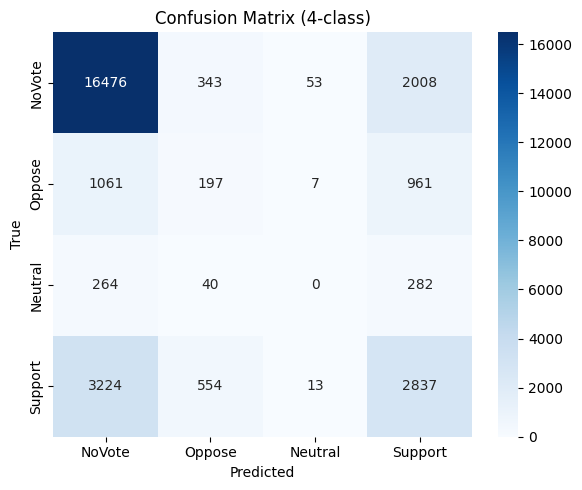

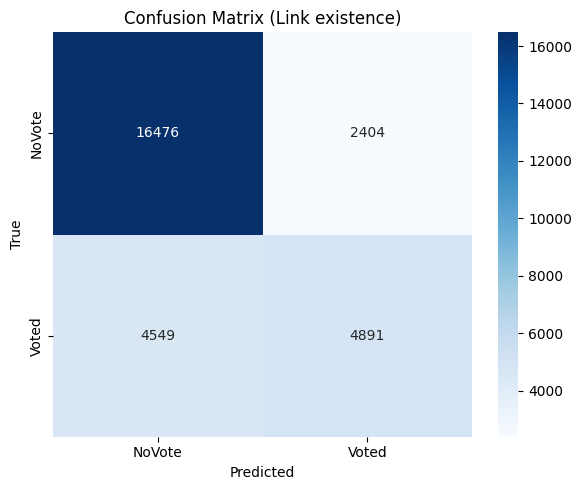

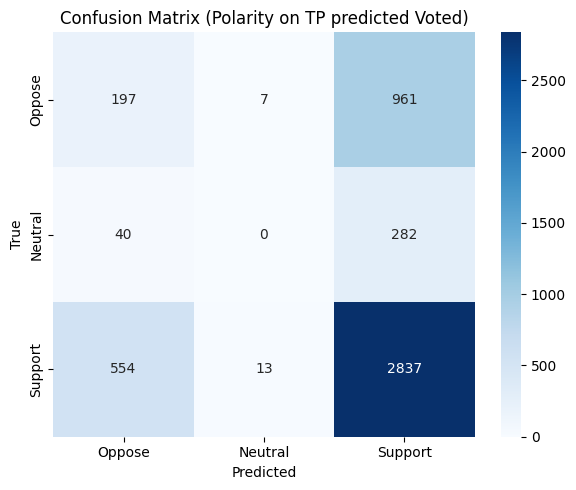

In [16]:
def plot_cm(cm, labels, title, normalize=False):
    if normalize:
        cm_plot = cm.astype(float)
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        cm_plot = cm.astype(int)   # <-- qui int
        fmt = "d"

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- 1) 4-class confusion matrix ----
labels_4 = ["NoVote", "Oppose", "Neutral", "Support"]
cm4 = confusion_matrix(y_true_4, y_pred_4, labels=[0,1,2,3])
plot_cm(cm4, labels_4, "Confusion Matrix (4-class)", normalize=False)
# plot_cm(cm4, labels_4, "Confusion Matrix (4-class) - normalized", normalize=True)

# ---- 2) Link existence confusion matrix (NoVote vs Voted) ----
y_true_link = (y_true_4 != 0).astype(int)
y_pred_link = (y_pred_4 != 0).astype(int)
cm_link = confusion_matrix(y_true_link, y_pred_link, labels=[0,1])
plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence)", normalize=False)
# plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence) - normalized", normalize=True)

# ---- 3) Polarity confusion matrix on TP edges where model predicts Voted ----
mask_tp = (y_true_4 != 0) & (y_pred_4 != 0)
y_true_pol = (y_true_4[mask_tp] - 1)  # {0,1,2}
y_pred_pol = (y_pred_4[mask_tp] - 1)  # {0,1,2}
cm_pol = confusion_matrix(y_true_pol, y_pred_pol, labels=[0,1,2])
plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix (Polarity on TP predicted Voted)", normalize=False)
# plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
#         "Confusion Matrix (Polarity on TP predicted Voted) - normalized", normalize=True)